In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
import torch.multiprocessing as mp

import os
import pickle

<br>

# Variables
---

## Path to model

In [7]:
# PATH_TO_MODEL="/checkpoint/qduval/inversecooking2.0/local/im2recipe-eval_im2recipe_vit16_multi_level_4_from_seed_0/2021-11-15_06-05-41/model_and_module.torch",
# PATH_TO_MODEL="/checkpoint/qduval/inversecooking2.0/local/im2recipe-eval_im2recipe_vit16_multi_level_4_seed_0/2021-11-05_13-41-05/model_and_module.torch",
PATH_TO_MODEL = "/checkpoint/qduval/inversecooking2.0/local/im2recipe-eval_im2recipe_vit16_multi_level_recipe_inference/2022-06-29_12-49-12/model_and_module.torch"

## Path to dataset

In [8]:
PATH_PREPROCESSED = "~/datasets/recipe1m/preprocessed_flavorgraph_substitutions_fixed_3"

## GISMo related paths

In [16]:
GISMO_CODE_PATH = "~/project/inversecooking2.0/gismo"
GISMO_PATH_PREPROCESSED = "~/baharef/inversecooking2.0/inversecooking2.0/preprocessed_data2/"
GISMO_OUTPUT_FOLDER = "~/baharef/out"

<br>

# Loading the model
---

In [10]:
def load_model(path: str, device: str):
    cp = torch.load(path, map_location="cpu")
    model = cp["model"].to(device)
    model.eval()
    data_module = cp["data_module"]
    return model, data_module


model, data_module = load_model(path=PATH_TO_MODEL, device="cuda:0")

In [12]:
file_path = os.path.join(os.path.expanduser(PATH_PREPROCESSED), "final_recipe1m_vocab_ingrs.pkl")
with open(file_path, "rb") as f:
    vocab = pickle.load(f)
    
    
def pick_random_ingr(vocab):
    n = len(vocab.idx2word)
    idx = np.random.randint(n - 2) + 1
    return vocab.idx2word[idx][0]


# Test the dataset load is working by picking a random ingredient
pick_random_ingr(vocab)

'sirloin'

In [17]:
from inv_cooking.utils.visualisation.im2recipe_viz import InteractiveSubstitutions

interactive_subs = InteractiveSubstitutions(
    model=model,
    data_module=data_module,
    use_pred_ingr=True,
    gismo_code_path=GISMO_CODE_PATH,
    gismo_preprocess_folder=GISMO_PATH_PREPROCESSED,
    gismo_output_folder=GISMO_OUTPUT_FOLDER,
)

<br>

# Interactive visualisation
---

<br>

# Interactive visualisation
---

## Visualise the recipe generation without substitutions

GROUND TRUTH RECIPE:
- all_purpose_flour
- baking_powder
- beer
- brown_sugar
- salt
- whole_wheat_flour
wheat beer bread
 -  preheat oven to 350 degrees f ( 175 degrees c ).
 -  lightly grease a 9x5 inch loaf pan.
 -  in a large mixing bowl, combine all-purpose flour, whole wheat flour, baking powder, salt and brown sugar.
 -  pour in beer, stir until a stiff batter is formed.
 -  it may be necessary to mix dough with your hands.
 -  scrape dough into prepared loaf pan.
 -  bake in preheated oven for 50 to 60 minutes, until a toothpick inserted into center of the loaf comes out clean.
GENERATED RECIPE:
- all_purpose_flour
- baking_powder
- beer
- brown_sugar
- salt
- whole_wheat_flour
beer bread
 -  preheat oven to 350 degrees.
 -  grease and flour a loaf pan.
 -  in a large bowl, combine the flours, baking powder, and salt.
 -  stir in the beer and brown sugar.
 -  pour into prepared loaf pan.
 -  bake for 1 hour.
 -  cool in pan for 10 minutes before removing to wire rack to cool co

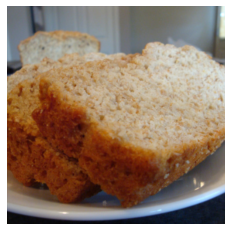

In [23]:
RECIPE_ID = "39818ba0d7" # '38d1d90c4d'

interactive_subs.use_pred_ingr = False
interactive_subs.sample_recipe(RECIPE_ID)
interactive_subs.use_pred_ingr = True

## Ask for substitutions on chosen ingredients

In [24]:
interactive_subs.compute_substitution("beer")  # Using GISMO

['beer',
 'water',
 'milk',
 'apple_juice',
 'beer',
 'beer',
 'warm_water',
 'applesauce',
 'buttermilk',
 'ale',
 'club_soda']

In [25]:
interactive_subs.compute_substitution("beer", lookup=True)  # Using Lookup-Table

['cinnamon',
 'pumpkin_pie_spice',
 'apple_pie_spice',
 'nutmeg',
 'allspice',
 'vanilla',
 'cardamom',
 'spice',
 'mixed_spice',
 'bun',
 'ginger']

## Chose the ingredient you prefer and generate recipe

- all_purpose_flour
- baking_powder
- brown_sugar
- salt
- water
- whole_wheat_flour
whole wheat bread
 -  combine flours, baking powder, and salt.
 -  add brown sugar and mix well.
 -  add water and mix well.
 -  pour into a greased loaf pan.
 -  bake at 350 degrees for 1 hour.


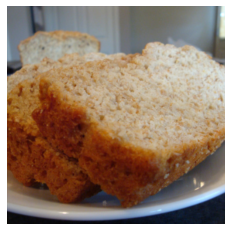

In [26]:
interactive_subs.substitute('beer', 'water')